In [2]:
# --- Imports & paths ---
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt

from joblib import load
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, roc_auc_score,
    accuracy_score, f1_score, confusion_matrix, roc_curve
)

# figure settings
%matplotlib inline

PROCESSED_DIR = "./data/processed"
FEATURES_DIR  = "./data/features"
MODELS_DIR    = "./models"
REPORT_DIR    = "./reports_step6"      # will also save PNGs here
os.makedirs(REPORT_DIR, exist_ok=True)

# --- Load engineered features ---
df = pd.read_parquet(f"{FEATURES_DIR}/features.parquet").copy()
df = df.sort_values("order_purchase_timestamp")

# feature columns (pick only those that exist to be robust)
num_cols = [c for c in [
    "price_sum","freight_sum","n_items","n_sellers","n_products","avg_price",
    "pay_total","pay_types","installments_max",
    "avg_product_weight","avg_product_length","avg_product_height","avg_product_width",
    "avg_distance_km",
    "purchase_month","purchase_dow","purchase_hour"
] if c in df.columns]
cat_cols = [c for c in ["customer_state","customer_city","main_category"] if c in df.columns]
feat_cols = num_cols + cat_cols

# time-based split 
TRAIN_END = "2017-06-01"
VALID_END = "2017-10-01"

train = df[df["order_purchase_timestamp"] < TRAIN_END]
valid = df[(df["order_purchase_timestamp"] >= TRAIN_END) & (df["order_purchase_timestamp"] < VALID_END)]
test  = df[df["order_purchase_timestamp"] >= VALID_END]

X_test = test[feat_cols]
y_days = test["actual_delivery_days"] if "actual_delivery_days" in test.columns else pd.Series(dtype=float)
y_late = test["is_late"] if "is_late" in test.columns else pd.Series(dtype=float)

print(f"Shapes — train:{train.shape}, valid:{valid.shape}, test:{test.shape}")
print("Features used:", feat_cols)

Shapes — train:(11695, 34), valid:(15887, 34), test:(71859, 34)
Features used: ['price_sum', 'freight_sum', 'n_items', 'n_sellers', 'n_products', 'avg_price', 'pay_total', 'pay_types', 'installments_max', 'avg_product_weight', 'avg_product_length', 'avg_product_height', 'avg_product_width', 'avg_distance_km', 'purchase_month', 'purchase_dow', 'purchase_hour', 'customer_state', 'customer_city', 'main_category']


In [3]:
# --- Load models if present ---
paths = {
    "reg":  os.path.join(MODELS_DIR, "delivery_time_rf.joblib"),   # from Step 4
    "late": os.path.join(MODELS_DIR, "late_delivery_clf.joblib"),  # from Step 5
}
models = {}
for k,p in paths.items():
    if os.path.exists(p):
        try:
            models[k] = load(p)
            print(f"Loaded: {k} <- {p}")
        except Exception as e:
            print(f"[WARN] cannot load {p}: {e}")
    else:
        print(f"[INFO] not found: {p}")

models

Loaded: reg <- ./models\delivery_time_rf.joblib
Loaded: late <- ./models\late_delivery_clf.joblib


{'reg': Pipeline(steps=[('pre',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('impute',
                                                                    SimpleImputer(strategy='median')),
                                                                   ('scale',
                                                                    StandardScaler())]),
                                                   ['price_sum', 'freight_sum',
                                                    'n_items', 'n_sellers',
                                                    'n_products', 'avg_price',
                                                    'pay_total', 'pay_types',
                                                    'installments_max',
                                                    'avg_product_weight',
                                                    'avg_product_length',
                              

C:\Users\12432\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[Regression] MAE=7.356 | RMSE=10.495 | n=70057


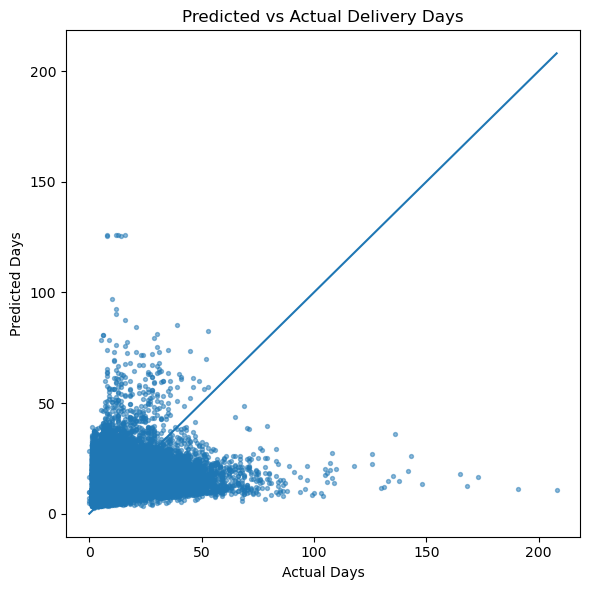

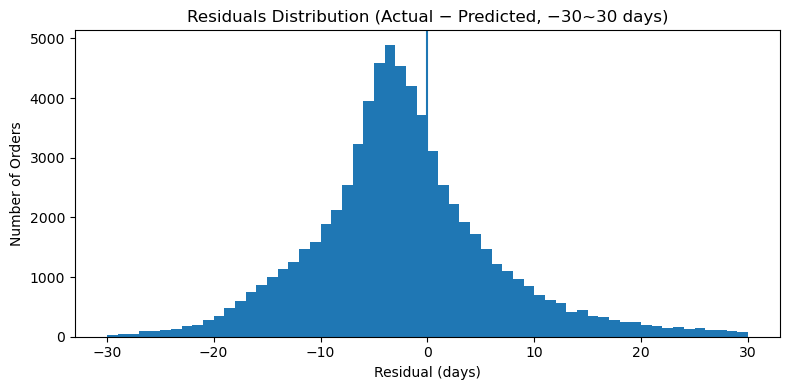

In [5]:
# --- Regression block: predict delivery days ---
if "reg" in models and not X_test.empty and not y_days.empty:
    reg = models["reg"]

    # evaluate only on rows with target present
    mask = test["actual_delivery_days"].notna()
    X_reg = X_test[mask]
    y_reg = test.loc[mask, "actual_delivery_days"].astype(float)

    y_pred = reg.predict(X_reg)

    # metrics
    mae  = mean_absolute_error(y_reg, y_pred)
    rmse = mean_squared_error(y_reg, y_pred, squared=False)  # avoid FutureWarning
    print(f"[Regression] MAE={mae:.3f} | RMSE={rmse:.3f} | n={len(y_reg)}")

    # save for possible export
    pred_df = pd.DataFrame({
        "order_id": test.loc[mask, "order_id"].values,
        "actual_days": y_reg.values,
        "pred_days":   y_pred
    })
    pred_df["residual"] = pred_df["actual_days"] - pred_df["pred_days"]

    # --- Plot 1: Pred vs Actual (with y=x) ---
    plt.figure(figsize=(6,6))
    plt.scatter(pred_df["actual_days"], pred_df["pred_days"], s=8, alpha=0.5)
    lo = float(np.nanmin([pred_df["actual_days"].min(), pred_df["pred_days"].min()]))
    hi = float(np.nanmax([pred_df["actual_days"].max(), pred_df["pred_days"].max()]))
    plt.plot([lo,hi],[lo,hi])  # y=x
    plt.xlabel("Actual Days"); plt.ylabel("Predicted Days")
    plt.title("Predicted vs Actual Delivery Days")
    plt.tight_layout(); plt.show()

    # --- Plot 2: Residuals histogram (focus −30~30) ---
    r = pred_df["residual"]
    r_clip = r[(r >= -30) & (r <= 30)]
    plt.figure(figsize=(8,4))
    plt.hist(r_clip, bins=60)
    plt.axvline(0.0)
    plt.title("Residuals Distribution (Actual − Predicted, −30~30 days)")
    plt.xlabel("Residual (days)"); plt.ylabel("Number of Orders")
    plt.tight_layout(); plt.show()


[Classifier] ACC=0.922 | F1=0.000 | ROC-AUC=0.536 | n=71859


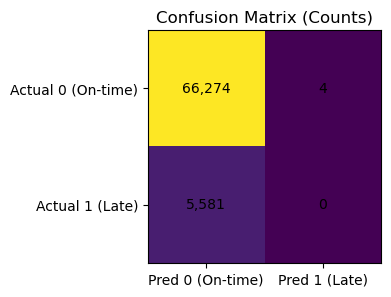

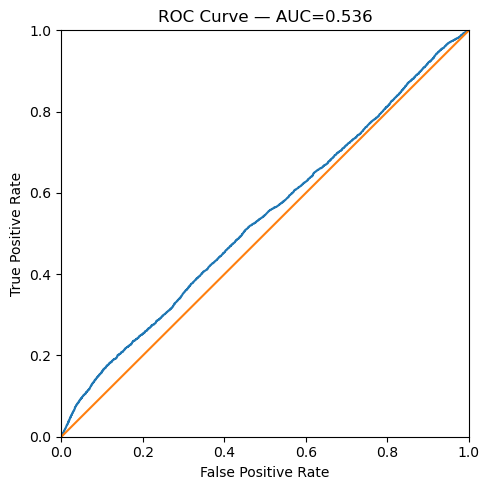

In [6]:
# --- Helper to get probability for classifiers without predict_proba ---
def get_probabilities(clf, X):
    if hasattr(clf, "predict_proba"):
        return clf.predict_proba(X)[:,1]
    elif hasattr(clf, "decision_function"):
        d = clf.decision_function(X)
        # min-max to [0,1] to serve as pseudo-probability for ROC curve
        d = (d - d.min()) / (d.max() - d.min() + 1e-12)
        return d
    else:
        # fallback: use predictions as 0/1
        return clf.predict(X).astype(float)

# --- Classification block: late vs on-time ---
if "late" in models and not X_test.empty and not y_late.empty:
    clf = models["late"]

    mask = test["is_late"].notna()
    X_clf = X_test[mask]
    y_true = test.loc[mask, "is_late"].astype(int).values

    y_pred = clf.predict(X_clf)
    y_proba = get_probabilities(clf, X_clf)

    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)
    print(f"[Classifier] ACC={acc:.3f} | F1={f1:.3f} | ROC-AUC={auc:.3f} | n={len(y_true)}")

    # Confusion matrix (counts)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    cm_df = pd.DataFrame(
        {"actual":[0,0,1,1], "pred":[0,1,0,1], "count": cm.ravel()}
    )

    # --- Plot 3: Confusion Matrix heatmap (counts) ---
    mat = cm.reshape(2,2)
    plt.figure(figsize=(4,4))
    plt.imshow(mat)
    plt.xticks([0,1], ["Pred 0 (On-time)","Pred 1 (Late)"])
    plt.yticks([0,1], ["Actual 0 (On-time)","Actual 1 (Late)"])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, f"{mat[i,j]:,}", ha="center", va="center")
    plt.title("Confusion Matrix (Counts)")
    plt.tight_layout(); plt.show()

    # --- Plot 4: ROC curve + baseline ---
    fpr, tpr, thr = roc_curve(y_true, y_proba)
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1])  # baseline y=x
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve — AUC={auc:.3f}")
    plt.tight_layout(); plt.show()




In [8]:
# Collect what we computed into one small table
rows = []

# Regression
if "reg" in models and not X_test.empty and not y_days.empty:
    mask = test["actual_delivery_days"].notna()
    y_reg = test.loc[mask, "actual_delivery_days"].astype(float)
    y_pred = models["reg"].predict(X_test[mask])
    rows += [
        {"task":"delivery_time_regression","metric":"MAE","value": float(mean_absolute_error(y_reg, y_pred))},
        {"task":"delivery_time_regression","metric":"RMSE","value": float(mean_squared_error(y_reg, y_pred, squared=False))}
    ]

# Classification
if "late" in models and not X_test.empty and not y_late.empty:
    mask = test["is_late"].notna()
    y_true = test.loc[mask, "is_late"].astype(int).values
    y_pred = models["late"].predict(X_test[mask])
    y_proba = get_probabilities(models["late"], X_test[mask])
    rows += [
        {"task":"late_delivery_classifier","metric":"Accuracy","value": float(accuracy_score(y_true, y_pred))},
        {"task":"late_delivery_classifier","metric":"F1","value": float(f1_score(y_true, y_pred))},
        {"task":"late_delivery_classifier","metric":"ROC-AUC","value": float(roc_auc_score(y_true, y_proba))}
    ]

metrics_df = pd.DataFrame(rows)
display(metrics_df)

metrics_df.to_csv(f"{REPORT_DIR}/metrics_summary.csv", index=False)


C:\Users\12432\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,task,metric,value
0,delivery_time_regression,MAE,7.356304
1,delivery_time_regression,RMSE,10.495289
2,late_delivery_classifier,Accuracy,0.922278
3,late_delivery_classifier,F1,0.000000
4,late_delivery_classifier,ROC-AUC,0.536341
